<a href="https://colab.research.google.com/github/Talendar/stocks_prices_prediction/blob/main/multi_stocks_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Prediction of Stocks Prices with Deep Learning**

#### **Imports and installs**

In [1]:
import numpy as np
import pandas as pd
from timeit import default_timer as timer

import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import display, Javascript, clear_output
import os
import shutil
from datetime import datetime

!pip install tensorflow==2.4.0-rc4 --quiet
import tensorflow as tf

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
tf.keras.backend.set_floatx('float64')

!pip install scikit-learn==0.24.0rc1 --quiet

!pip install yahooquery --quiet
from yahooquery import Ticker

!rm -rf stocks
!git clone https://github.com/Talendar/stocks_prices_prediction stocks --quiet

%load_ext autoreload
%autoreload 2

from stocks.aux.stocks_data import MultiStocksDataset
from stocks.aux.eval import *
from stocks.aux.normalization import *
from stocks.aux.tf_callbacks import ClearCallback

try:
  from google.colab import files
  COLAB = True
except ImportError:
  COLAB = False

if COLAB: Javascript("google.colab.output.setIframeHeight('100px');")

####**Settings**

In [50]:
NUM_SESSIONS = 3  # number of previous trading sessions the model will analyse in order to make a prediction
NORMALIZE_LABELS = True

TRAIN_PC, VAL_PC, TEST_PC = .85, .10, .05
assert (TRAIN_PC + VAL_PC + TEST_PC) == 1

NUM_SESSIONS_PER_STOCK_PER_BATCH = 2
MAX_ZERO_VOL_PC = 0.2
INTERVAL = "1d"

LABELS_NAMES = [    # values that the model will try to predict
    "open", "low", "high",
]

NAME_LIST = set([
    # South America
    "^BVSP",                                        # Brazil
    # North America
    "^DJI", "^GSPC", "^IXIC", "^NYA", "^RUT",       # US
    "^MXX",                                         # Mexico
    "^GSPTSE",                                      # Canada
    # Europe
    "^FTSE", "^FCHI", "^GDAXI", "^IBEX", "^AEX", "^ATX", #"^N100",  "^BFX", 
    # Asia
    "000001.SS", "^HSI",                            # China "^TWII"  "399001.SZ"
    "^N225",                                        # Japan
    "^KS11",                                        # S. Korea 
    "^BSESN",                                       # India
    # Oceania
    "^AORD",                                        # Australia
    
])

# loading stocks with specific params:
STOCKS = {
}

# loading stocks from NAME_LIST with default info (same params for all):
STOCKS.update({name: {"start": "2006-01-01",
                      "end": "2020-12-08",
                      "period": None} \
               for name in NAME_LIST})

## **1) Preparing the data**

####**1.1) Fetching and pre-processing the data**

In [51]:
ts = timer()
sess_counter = 0

multi_data = {}
for name, info in STOCKS.items():
    hist = Ticker(name).history(
        start=info["start"],
        end=info["end"],
        period=info["period"], 
        interval=INTERVAL
    ).reset_index("symbol", drop=True)
    hist = hist[["high", "close", "open", "low", "volume"]]
    
    zero_vols_pc = hist["volume"].isin([0]).sum() / len(hist)
    if zero_vols_pc > MAX_ZERO_VOL_PC:
        print(f"[WARNING] {100*zero_vols_pc : .2f}% of the " + \
              f"volumes of {name} are 0! Skipping symbol...")
    else:
        sess_counter += len(hist)
        multi_data[name] = hist


multi_data = MultiStocksDataset(
    stocks=multi_data, 
    num_sessions=NUM_SESSIONS,
    labels_names=LABELS_NAMES,
    batch_size=len(multi_data) * NUM_SESSIONS_PER_STOCK_PER_BATCH,
    data_split_pc=(TRAIN_PC, VAL_PC, TEST_PC),
    feature_normalization=(min_max_norm, min_max_denorm), 
    label_normalization=(min_max_norm, min_max_denorm) \
                        if NORMALIZE_LABELS else None,
)

print(f"\nDone! Multi-stocks dataset ready. Elapsed time: {timer() - ts : .2f}s")
print(f"Number of trading sessions: {sess_counter}")


Done! Multi-stocks dataset ready. Elapsed time:  7.24s
Number of trading sessions: 74729


#### **1.2) Inspecting the data**



###################################   ^MXX   ###################################

. Period: from 2006-01-02 to 2020-12-07
. Trading sessions: 3739
. Zero volumes:  0.16%
. Data:



,high,close,open,low,volume
date,,,,,
2006-01-02,17926.970703,17925.699219,17802.710938,17786.240234,8889000.0
2006-01-03,18503.189453,18500.689453,17925.449219,17925.449219,127472400.0
2006-01-04,18687.839844,18669.230469,18501.949219,18501.949219,132986000.0
2006-01-05,18768.740234,18608.339844,18669.230469,18592.689453,103485400.0
2006-01-06,18786.269531,18736.779297,18608.339844,18575.750000,63643200.0
...,...,...,...,...,...
2020-12-01,43204.101562,42895.628906,41987.429688,41902.769531,224469600.0
2020-12-02,43730.960938,43674.828125,43010.480469,42956.730469,174294200.0
2020-12-03,44013.109375,43934.210938,43512.269531,43477.660156,175436600.0



. Statistics:



,high,close,open,low,volume
count,3739.000000,3739.000000,3739.000000,3739.000000,3.739000e+03
mean,37812.389210,37565.494111,37561.858303,37301.536467,1.800982e+08
std,8705.854600,8702.393425,8708.442624,8703.493901,8.965917e+07
min,16870.410156,16653.150391,16674.220703,16464.619141,0.000000e+00
25%,31647.469727,31387.059570,31387.455078,31150.160156,1.323790e+08
50%,40228.730469,39963.261719,39939.800781,39697.101562,1.657234e+08
75%,44554.789062,44320.351562,44334.955078,44063.375000,2.109920e+08
max,51772.371094,51713.378906,51590.480469,51524.230469,1.759968e+09



. Plot:



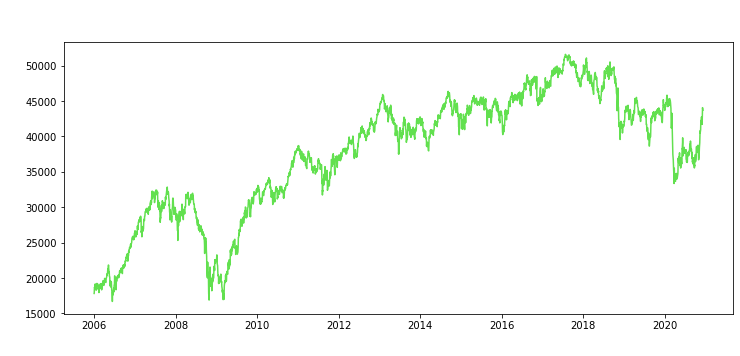



################################################################################




###################################   ^BVSP   ###################################

. Period: from 2006-01-02 to 2020-12-07
. Trading sessions: 3687
. Zero volumes:  5.78%
. Data:



,high,close,open,low,volume
date,,,,,
2006-01-02,33519.0,33507.0,33462.0,32860.0,0.0
2006-01-03,34563.0,34541.0,33507.0,33507.0,0.0
2006-01-04,35223.0,35002.0,34540.0,34540.0,0.0
2006-01-05,35088.0,34936.0,35006.0,34681.0,0.0
2006-01-06,35529.0,35475.0,35170.0,34940.0,0.0
...,...,...,...,...,...
2020-12-01,111840.0,111335.0,108897.0,108897.0,11324800.0
2020-12-02,112315.0,111814.0,111402.0,110579.0,9814300.0
2020-12-03,113377.0,112919.0,111874.0,111874.0,11474200.0



. Statistics:



,high,close,open,low,volume
count,3687.000000,3687.000000,3687.000000,3687.000000,3.687000e+03
mean,63449.823162,62817.099810,62794.981828,62146.034717,1.010455e+07
std,18347.826714,18250.433491,18232.564628,18129.181714,2.750507e+07
min,31480.000000,29435.000000,29438.000000,29435.000000,0.000000e+00
25%,51599.000000,51122.500000,51122.000000,50460.000000,2.096200e+06
50%,59542.000000,59082.000000,59081.000000,58365.000000,3.251000e+06
75%,69889.000000,69343.500000,69339.000000,68719.500000,4.610600e+06
max,119593.000000,119528.000000,119528.000000,118108.000000,2.322653e+08



. Plot:



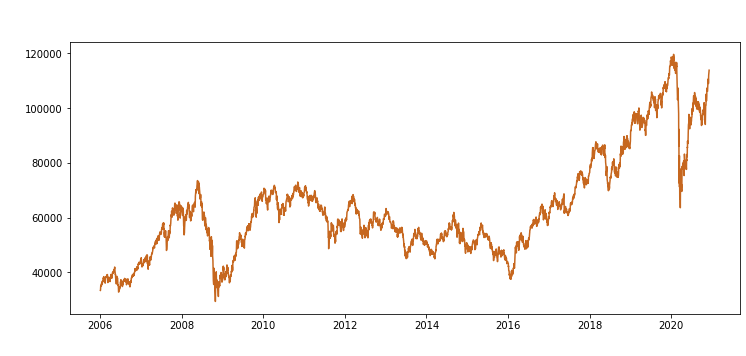



################################################################################




###################################   ^NYA   ###################################

. Period: from 2006-01-03 to 2020-12-07
. Trading sessions: 3759
. Zero volumes:  0.48%
. Data:



,high,close,open,low,volume
date,,,,,
2006-01-03,7916.470215,7912.410156,7753.970215,7753.970215,2554570000
2006-01-04,7967.060059,7962.939941,7912.399902,7911.120117,2515330000
2006-01-05,7965.930176,7944.060059,7962.939941,7928.589844,2433340000
2006-01-06,8036.990234,8031.660156,7944.060059,7944.060059,2446560000
2006-01-09,8055.580078,8053.419922,8031.689941,8026.020020,2301490000
...,...,...,...,...,...
2020-12-01,14233.459961,14146.639648,14183.450195,14131.330078,5403660000
2020-12-02,14198.790039,14188.240234,14104.059570,14076.709961,5029620000
2020-12-03,14283.730469,14217.179688,14210.540039,14184.490234,5091760000



. Statistics:



,high,close,open,low,volume
count,3759.000000,3759.000000,3759.000000,3759.000000,3.759000e+03
mean,9790.498619,9738.500083,9738.169134,9679.193041,3.871104e+09
std,2144.573032,2150.365919,2150.602337,2157.674653,1.218469e+09
min,4321.759766,4226.310059,4226.310059,4181.750000,0.000000e+00
25%,8154.364990,8113.210205,8112.640137,8074.439941,3.172730e+09
50%,9791.169922,9724.490234,9721.110352,9664.009766,3.655320e+09
75%,11253.709961,11209.265137,11213.920410,11170.665039,4.327580e+09
max,14417.400391,14417.330078,14375.549805,14314.469727,1.145623e+10



. Plot:



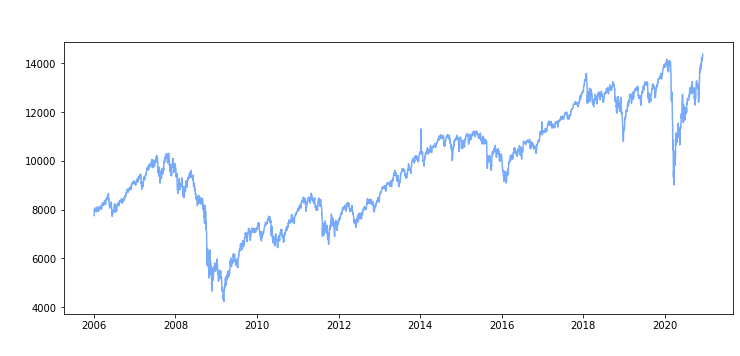



################################################################################




###################################   ^GSPTSE   ###################################

. Period: from 2006-01-03 to 2020-12-07
. Trading sessions: 3750
. Zero volumes:  0.08%
. Data:



,high,close,open,low,volume
date,,,,,
2006-01-03,11456.099609,11441.599609,11304.599609,11272.299805,139604800
2006-01-04,11505.500000,11501.500000,11409.000000,11384.700195,164030000
2006-01-05,11507.700195,11507.700195,11475.000000,11447.200195,149329700
2006-01-06,11646.900391,11620.500000,11547.700195,11507.700195,182804300
2006-01-09,11640.500000,11565.200195,11618.400391,11565.200195,196623900
...,...,...,...,...,...
2020-12-01,17471.199219,17296.900391,17431.300781,17285.300781,296753900
2020-12-02,17358.300781,17358.199219,17278.099609,17220.900391,261964200
2020-12-03,17452.900391,17398.000000,17386.000000,17382.000000,251025700



. Statistics:



,high,close,open,low,volume
count,3750.000000,3750.000000,3750.000000,3750.000000,3.750000e+03
mean,13705.462765,13633.967739,13637.168690,13556.049653,2.054620e+08
std,1910.316638,1927.122274,1926.490161,1946.315124,7.669430e+07
min,7695.299805,7566.899902,7527.399902,7480.000000,0.000000e+00
25%,12307.199707,12230.724609,12241.024902,12159.349854,1.674426e+08
50%,13691.000000,13621.449707,13619.900391,13532.800293,1.988056e+08
75%,15235.725098,15172.975098,15177.324707,15113.774902,2.341896e+08
max,17970.500000,17944.099609,17936.500000,17860.599609,9.440374e+08



. Plot:



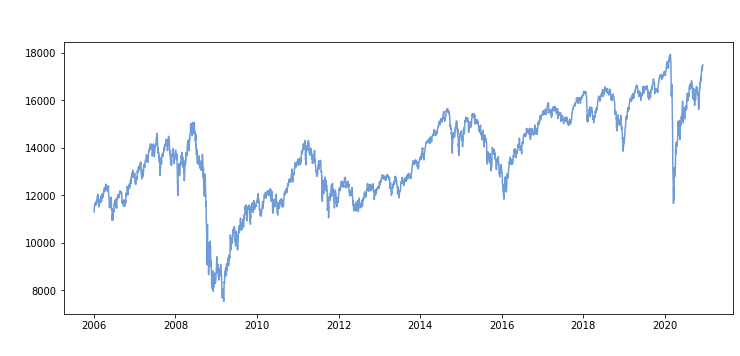



################################################################################




###################################   ^GDAXI   ###################################

. Period: from 2006-01-02 to 2020-12-07
. Trading sessions: 3785
. Zero volumes:  1.98%
. Data:



,high,close,open,low,volume
date,,,,,
2006-01-02,5451.569824,5449.979980,5410.240234,5409.279785,36148300.0
2006-01-03,5496.459961,5460.680176,5451.339844,5440.740234,105746000.0
2006-01-04,5523.669922,5523.620117,5494.459961,5477.600098,108624100.0
2006-01-05,5526.410156,5516.529785,5521.859863,5502.250000,102413000.0
2006-01-06,5537.580078,5536.319824,5521.520020,5507.919922,90224400.0
...,...,...,...,...,...
2020-12-01,13434.299805,13382.299805,13371.660156,13334.990234,66675500.0
2020-12-02,13359.269531,13313.240234,13341.910156,13272.469727,63822100.0
2020-12-03,13307.540039,13252.860352,13304.830078,13223.929688,64310300.0



. Statistics:



,high,close,open,low,volume
count,3785.000000,3785.000000,3785.000000,3785.000000,3.785000e+03
mean,8856.253686,8795.222817,8796.026246,8729.801791,1.153965e+08
std,2693.937676,2686.171756,2686.837551,2679.440027,5.369083e+07
min,3706.320068,3666.409912,3677.070068,3588.889893,0.000000e+00
25%,6440.560059,6401.060059,6394.270020,6335.220215,8.209780e+07
50%,8246.080078,8196.179688,8197.719727,8137.529785,1.048807e+08
75%,11480.179688,11419.620117,11422.620117,11345.099609,1.371905e+08
max,13795.240234,13789.000000,13774.440430,13754.040039,4.940122e+08



. Plot:



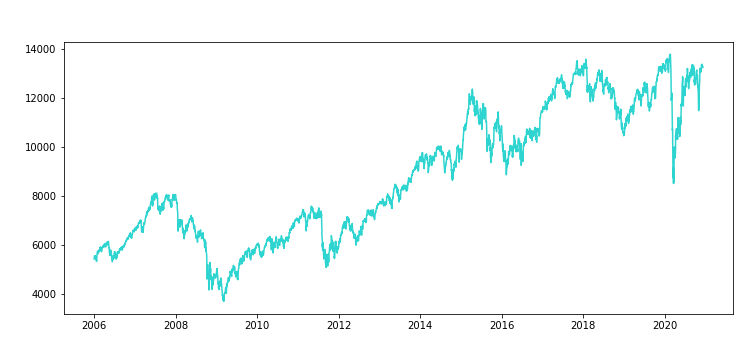



################################################################################




###################################   ^N225   ###################################

. Period: from 2006-01-04 to 2020-12-08
. Trading sessions: 3652
. Zero volumes:  0.33%
. Data:



,high,close,open,low,volume
date,,,,,
2006-01-04,16361.540039,16361.540039,16294.650391,16250.759766,94300.0
2006-01-05,16474.519531,16425.369141,16441.269531,16368.509766,164500.0
2006-01-06,16479.550781,16428.210938,16408.310547,16320.429688,170400.0
2006-01-10,16487.050781,16124.349609,16487.050781,16124.349609,154600.0
2006-01-11,16363.589844,16363.589844,16164.919922,16005.240234,146200.0
...,...,...,...,...,...
2020-12-02,26889.900391,26800.980469,26884.990234,26695.279297,80200.0
2020-12-03,26868.089844,26809.369141,26740.300781,26719.230469,69500.0
2020-12-04,26799.830078,26751.240234,26697.259766,26646.080078,61600.0



. Statistics:



,high,close,open,low,volume
count,3652.000000,3652.000000,3652.000000,3652.000000,3652.000000
mean,15724.557162,15631.146743,15633.795111,15534.366091,129282.338445
std,4854.516687,4843.792710,4841.699696,4827.256538,51489.194594
min,7100.770020,7054.979980,7059.770020,6994.899902,0.000000
25%,10462.292725,10399.877197,10405.410156,10343.927734,97000.000000
50%,16103.875000,15962.540039,15987.854980,15845.500000,125200.000000
75%,19787.042480,19697.864746,19699.432129,19604.454590,153025.000000
max,26894.250000,26809.369141,26894.250000,26719.230469,595200.000000



. Plot:



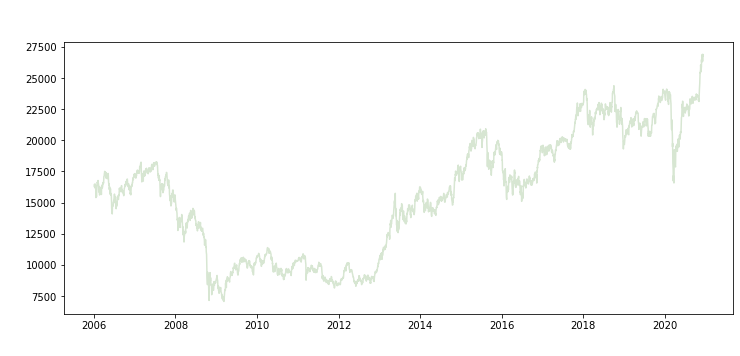



################################################################################




###################################   ^IXIC   ###################################

. Period: from 2006-01-03 to 2020-12-07
. Trading sessions: 3759
. Zero volumes:  0.00%
. Data:



,high,close,open,low,volume
date,,,,,
2006-01-03,2249.679932,2243.739990,2216.530029,2189.909912,1998300000
2006-01-04,2265.280029,2263.459961,2246.959961,2246.070068,1887560000
2006-01-05,2277.560059,2276.870117,2264.929932,2264.500000,1891750000
2006-01-06,2306.719971,2305.620117,2289.209961,2281.010010,2233640000
2006-01-09,2322.629883,2318.689941,2306.179932,2303.129883,1949140000
...,...,...,...,...,...
2020-12-01,12405.790039,12355.110352,12313.360352,12263.929688,6467180000
2020-12-02,12360.059570,12349.370117,12285.750000,12217.349609,5150820000
2020-12-03,12439.019531,12377.179688,12369.259766,12356.990234,5182100000



. Statistics:



,high,close,open,low,volume
count,3759.000000,3759.000000,3759.000000,3759.000000,3.759000e+03
mean,4423.391735,4397.175619,4396.267900,4366.420255,2.123709e+09
std,2434.898995,2420.408739,2419.680397,2402.891432,6.504127e+08
min,1316.150024,1268.640015,1284.839966,1265.520020,1.494100e+08
25%,2461.569946,2450.354980,2444.949951,2429.489990,1.776530e+09
50%,3485.449951,3469.219971,3473.159912,3452.310059,1.984230e+09
75%,5867.425049,5858.724854,5855.915039,5829.649902,2.258520e+09
max,12536.230469,12519.950195,12461.000000,12460.549805,7.693430e+09



. Plot:



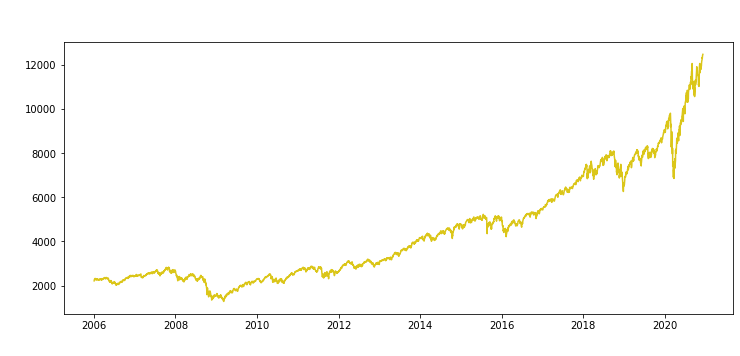



################################################################################




###################################   ^KS11   ###################################

. Period: from 2006-01-02 to 2020-12-08
. Trading sessions: 3678
. Zero volumes:  0.22%
. Data:



,high,close,open,low,volume
date,,,,,
2006-01-02,1389.270020,1389.270020,1383.319946,1370.609985,396400.0
2006-01-03,1394.920044,1394.869995,1393.140015,1376.170044,541200.0
2006-01-04,1412.150024,1402.109985,1408.189941,1400.079956,528000.0
2006-01-05,1405.310059,1395.510010,1405.310059,1378.959961,538000.0
2006-01-06,1412.790039,1412.780029,1399.229980,1395.260010,587800.0
...,...,...,...,...,...
2020-12-02,2677.260010,2675.899902,2645.879883,2644.530029,1076200.0
2020-12-03,2696.219971,2696.219971,2686.379883,2672.850098,817100.0
2020-12-04,2742.770020,2731.449951,2705.340088,2705.340088,1778900.0



. Statistics:



,high,close,open,low,volume
count,3678.000000,3678.000000,3678.000000,3678.000000,3.678000e+03
mean,1911.677161,1901.000881,1901.999099,1893.744478,5.514931e+05
std,320.353851,321.008713,321.213716,428.497097,5.921117e+06
min,966.409973,938.750000,916.849976,892.159973,0.000000e+00
25%,1735.719971,1725.102478,1725.977478,1712.410004,2.978000e+05
50%,1970.804993,1962.895020,1963.500000,1952.829956,3.704000e+05
75%,2083.919983,2072.897461,2074.744995,2063.707520,4.704000e+05
max,2754.010010,2745.439941,2745.129883,19025.550781,2.607250e+08



. Plot:



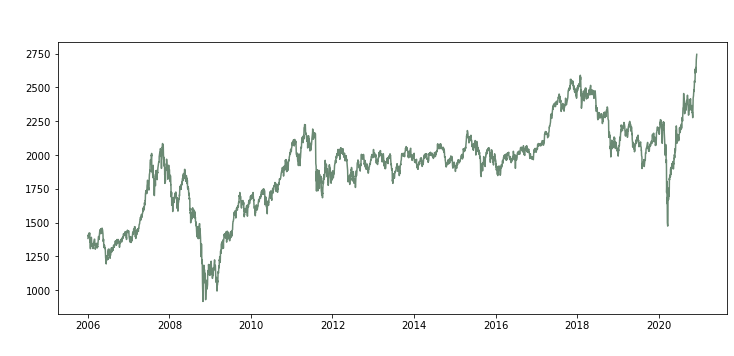



################################################################################




###################################   ^BSESN   ###################################

. Period: from 2006-01-02 to 2020-12-07
. Trading sessions: 3660
. Zero volumes:  0.00%
. Data:



,high,close,open,low,volume
date,,,,,
2006-01-02,9457.089844,9390.139648,9422.490234,9366.089844,14000.0
2006-01-03,9546.780273,9539.370117,9401.830078,9390.790039,13200.0
2006-01-04,9664.940430,9648.080078,9523.290039,9523.290039,21400.0
2006-01-05,9679.719727,9617.740234,9638.269531,9571.309570,19200.0
2006-01-06,9680.919922,9640.290039,9635.089844,9535.660156,16000.0
...,...,...,...,...,...
2020-12-01,44730.789062,44655.441406,44435.828125,44118.101562,16000.0
2020-12-02,44729.640625,44618.039062,44729.519531,44169.968750,16000.0
2020-12-03,44953.011719,44632.648438,44902.019531,44551.421875,30700.0



. Statistics:



,high,close,open,low,volume
count,3660.000000,3660.000000,3660.000000,3660.000000,3.660000e+03
mean,23357.919602,23194.095410,23220.812498,23036.979242,1.038205e+05
std,8922.399620,8892.776772,8909.467272,8870.183451,1.236294e+06
min,8259.219727,8160.399902,8103.750000,7697.390137,8.000000e+02
25%,16816.271973,16676.966797,16668.225098,16508.760742,1.060000e+04
50%,20190.709961,20036.759766,20070.174805,19926.934570,1.440000e+04
75%,29498.197754,29333.262695,29352.597168,29143.728027,2.040000e+04
max,45458.921875,45426.968750,45099.921875,45024.468750,3.181510e+07



. Plot:



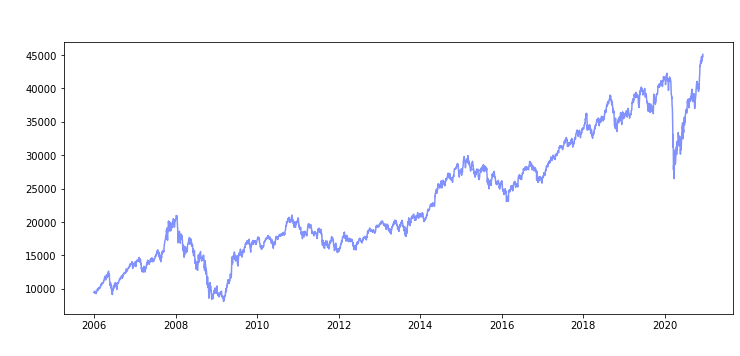



################################################################################




###################################   ^AORD   ###################################

. Period: from 2006-01-03 to 2020-12-08
. Trading sessions: 3776
. Zero volumes:  0.90%
. Data:



,high,close,open,low,volume
date,,,,,
2006-01-03,4726.700195,4721.100098,4707.799805,4698.200195,2.487344e+08
2006-01-04,4767.700195,4765.100098,4730.799805,4730.799805,4.747986e+08
2006-01-05,4773.299805,4757.899902,4765.299805,4751.799805,4.698218e+08
2006-01-06,4758.200195,4736.399902,4758.200195,4730.799805,3.747378e+08
2006-01-09,4778.700195,4775.799805,4747.700195,4747.500000,4.776910e+08
...,...,...,...,...,...
2020-12-02,6840.799805,6811.299805,6812.200195,6784.399902,1.024029e+09
2020-12-03,6861.700195,6847.299805,6811.299805,6811.299805,9.869194e+08
2020-12-04,6879.399902,6865.299805,6847.299805,6846.399902,8.728332e+08



. Statistics:



,high,close,open,low,volume
count,3776.000000,3776.000000,3776.000000,3776.000000,3.776000e+03
mean,5359.099549,5331.144596,5330.719150,5302.059901,9.423311e+08
std,798.869129,799.366135,798.830664,798.911984,3.445061e+08
min,3133.100098,3111.699951,3116.000000,3090.800049,0.000000e+00
25%,4806.025024,4783.924805,4782.449951,4760.149902,7.396405e+08
50%,5378.199951,5350.050049,5350.100098,5316.550049,8.701603e+08
75%,5928.150024,5902.675049,5901.424927,5868.924927,1.082952e+09
max,7289.700195,7255.200195,7255.200195,7237.399902,5.636657e+09



. Plot:



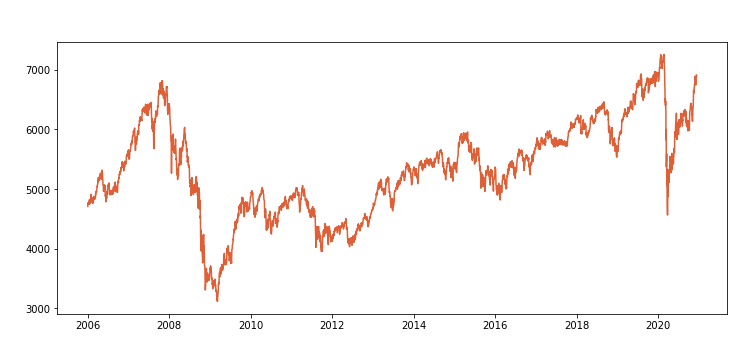



################################################################################




###################################   ^RUT   ###################################

. Period: from 2006-01-03 to 2020-12-07
. Trading sessions: 3758
. Zero volumes:  0.00%
. Data:



,high,close,open,low,volume
date,,,,,
2006-01-03,685.229980,684.049988,673.219971,666.580017,25545700.0
2006-01-04,690.159973,689.250000,684.049988,683.419983,25153300.0
2006-01-05,692.409973,691.770020,689.250000,687.659973,24333400.0
2006-01-06,700.440002,699.390015,691.770020,691.770020,24465600.0
2006-01-09,708.039978,706.239990,699.390015,699.390015,23014900.0
...,...,...,...,...,...
2020-12-01,1848.020020,1836.050049,1822.920044,1822.920044,54036600.0
2020-12-02,1842.530029,1838.030029,1833.079956,1817.020020,50296200.0
2020-12-03,1860.349976,1848.699951,1838.520020,1838.520020,50917600.0



. Statistics:



,high,close,open,low,volume
count,3758.000000,3758.000000,3758.000000,3758.000000,3.758000e+03
mean,1042.168984,1034.959908,1034.784268,1026.723058,3.969375e+07
std,355.684296,354.545008,354.455272,353.320771,5.174832e+07
min,355.049988,343.260010,347.380005,342.589996,5.362000e+06
25%,743.162521,737.762497,737.450012,731.597504,3.182910e+07
50%,992.915009,987.290009,986.589996,976.889984,3.661520e+07
75%,1359.207458,1352.067505,1350.907532,1341.259979,4.336555e+07
max,1897.439941,1892.449951,1892.719971,1886.780029,3.125950e+09



. Plot:



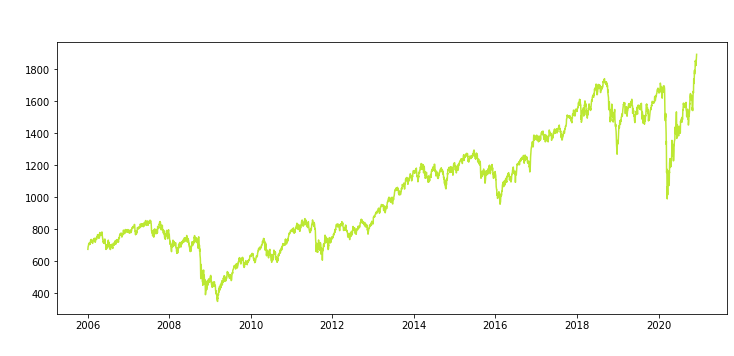



################################################################################




###################################   000001.SS   ###################################

. Period: from 2006-01-04 to 2020-12-07
. Trading sessions: 3627
. Zero volumes:  0.11%
. Data:



,high,close,open,low,volume
date,,,,,
2006-01-04,1181.004028,1180.963013,1163.878052,1161.906006,23200.0
2006-01-05,1197.837036,1197.269043,1183.305054,1180.451050,29400.0
2006-01-06,1215.536011,1209.421997,1198.811035,1191.614014,34400.0
2006-01-09,1217.313965,1215.667969,1210.319946,1205.248047,28800.0
2006-01-10,1220.755981,1220.618042,1215.848022,1203.651001,26800.0
...,...,...,...,...,...
2020-12-01,3457.639893,3451.939941,3388.989990,3386.909912,316200.0
2020-12-02,3465.729004,3449.381104,3453.518066,3435.871094,312800.0
2020-12-03,3452.160889,3442.135986,3448.540039,3428.803955,298500.0



. Statistics:



,high,close,open,low,volume
count,3627.000000,3627.000000,3627.000000,3627.000000,3627.000000
mean,2873.730733,2850.308699,2847.019124,2819.720840,154654.342432
std,774.073716,763.801903,764.089913,750.048526,115988.783288
min,1181.004028,1180.963013,1163.878052,1161.906006,0.000000
25%,2323.002075,2306.207520,2302.085938,2286.395508,79850.000000
50%,2892.080078,2871.031006,2865.695068,2840.488037,126000.000000
75%,3219.631470,3196.740479,3196.618896,3173.815063,188450.000000
max,6124.043945,6092.057129,6057.428223,6040.712891,857100.000000



. Plot:



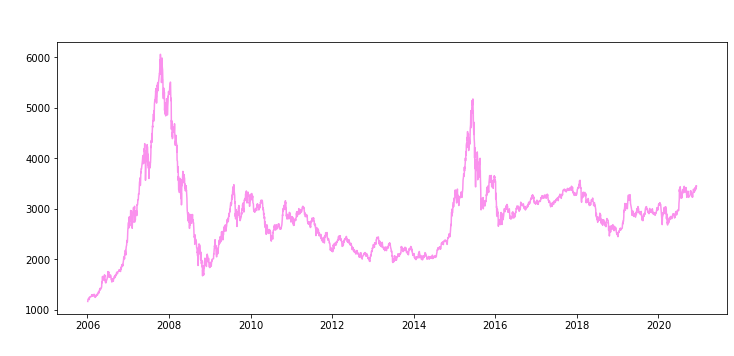



################################################################################




###################################   ^FCHI   ###################################

. Period: from 2006-01-02 to 2020-12-07
. Trading sessions: 3816
. Zero volumes:  0.81%
. Data:



,high,close,open,low,volume
date,,,,,
2006-01-02,4757.540039,4754.919922,4731.919922,4727.089844,35923200.0
2006-01-03,4803.229980,4776.979980,4761.950195,4755.720215,93725400.0
2006-01-04,4838.520020,4838.520020,4820.899902,4799.189941,112403400.0
2006-01-05,4849.669922,4835.089844,4839.089844,4826.310059,107184400.0
2006-01-06,4867.149902,4867.149902,4843.160156,4839.750000,111654200.0
...,...,...,...,...,...
2020-12-01,5589.680176,5581.640137,5542.459961,5529.250000,0.0
2020-12-02,5585.870117,5583.009766,5563.049805,5549.790039,0.0
2020-12-03,5584.100098,5574.359863,5581.529785,5546.290039,0.0



. Statistics:



,high,close,open,low,volume
count,3816.000000,3816.000000,3816.000000,3816.000000,3.816000e+03
mean,4542.396613,4511.303798,4512.360543,4478.141731,1.222508e+08
std,825.290047,828.153087,827.387100,830.794027,5.138585e+07
min,2552.989990,2519.290039,2519.429932,2465.459961,0.000000e+00
25%,3862.769958,3835.162537,3834.507507,3807.632507,8.702315e+07
50%,4536.729980,4509.084961,4505.024902,4478.354980,1.146510e+08
75%,5234.125000,5207.997559,5205.172485,5175.015015,1.466683e+08
max,6168.149902,6168.149902,6157.330078,6112.290039,5.312476e+08



. Plot:



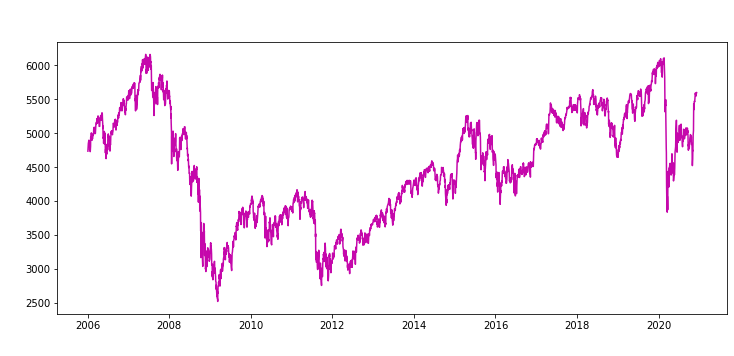



################################################################################




###################################   ^DJI   ###################################

. Period: from 2006-01-03 to 2020-12-07
. Trading sessions: 3759
. Zero volumes:  0.00%
. Data:



,high,close,open,low,volume
date,,,,,
2006-01-03,10862.780273,10847.410156,10718.299805,10684.450195,302950000
2006-01-04,10892.639648,10880.150391,10843.969727,10833.900391,271490000
2006-01-05,10908.250000,10882.150391,10880.389648,10843.650391,250910000
2006-01-06,10968.839844,10959.309570,10875.450195,10875.450195,291740000
2006-01-09,11020.150391,11011.900391,10959.469727,10944.429688,248240000
...,...,...,...,...,...
2020-12-01,30083.310547,29823.919922,29797.500000,29797.500000,429510000
2020-12-02,29902.509766,29883.789062,29695.089844,29599.289062,385280000
2020-12-03,30110.880859,29969.519531,29920.830078,29877.269531,405680000



. Statistics:



,high,close,open,low,volume
count,3759.000000,3759.000000,3759.000000,3759.000000,3.759000e+03
mean,16542.861168,16452.282088,16449.161419,16350.789681,2.259917e+08
std,5841.585960,5820.011399,5820.819085,5797.689216,1.281459e+08
min,6709.609863,6547.049805,6547.009766,6469.950195,8.410000e+06
25%,12024.129883,11951.500000,11946.834961,11834.074707,1.222100e+08
50%,15113.419922,15063.120117,15056.200195,14971.200195,2.108800e+08
75%,20709.809570,20650.755859,20639.184570,20535.474609,2.956100e+08
max,30233.029297,30218.259766,30233.029297,29989.560547,2.190810e+09



. Plot:



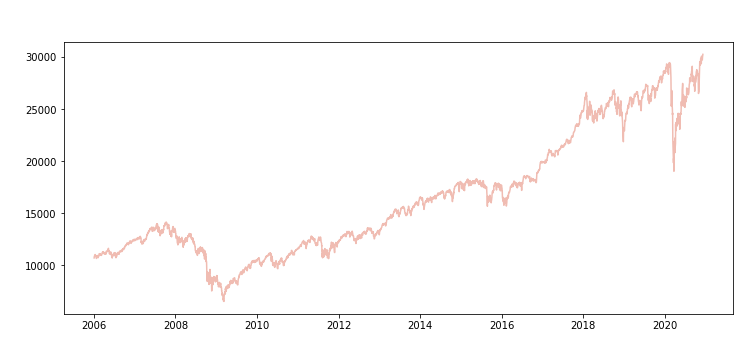



################################################################################




###################################   ^HSI   ###################################

. Period: from 2006-01-03 to 2020-12-07
. Trading sessions: 3674
. Zero volumes:  0.30%
. Data:



,high,close,open,low,volume
date,,,,,
2006-01-03,14945.049805,14944.769531,14843.969727,14843.969727,2.503830e+08
2006-01-04,15208.860352,15200.059570,15112.759766,15085.440430,5.652202e+08
2006-01-05,15373.790039,15271.129883,15313.849609,15261.820312,5.142946e+08
2006-01-06,15347.000000,15344.440430,15327.290039,15252.480469,3.977274e+08
2006-01-09,15602.879883,15547.429688,15497.969727,15497.719727,5.815424e+08
...,...,...,...,...,...
2020-12-01,26662.179688,26567.679688,26422.710938,26375.240234,3.564239e+09
2020-12-02,26670.119141,26532.580078,26670.119141,26379.480469,3.704087e+09
2020-12-03,26781.990234,26728.500000,26623.419922,26556.019531,2.830414e+09



. Statistics:



,high,close,open,low,volume
count,3674.000000,3674.000000,3674.000000,3674.000000,3.674000e+03
mean,22920.396666,22773.845523,22786.674636,22621.073169,1.773469e+09
std,3886.451590,3874.542131,3880.236501,3865.478453,8.027402e+08
min,11747.110352,11015.839844,11154.570312,10676.290039,0.000000e+00
25%,20626.102051,20514.907715,20518.874512,20389.606934,1.327773e+09
50%,22934.425781,22804.940430,22813.709961,22677.215820,1.653826e+09
75%,25254.022949,25120.705078,25090.643066,24908.562500,2.088287e+09
max,33484.078125,33154.121094,33335.480469,32897.039062,9.799120e+09



. Plot:



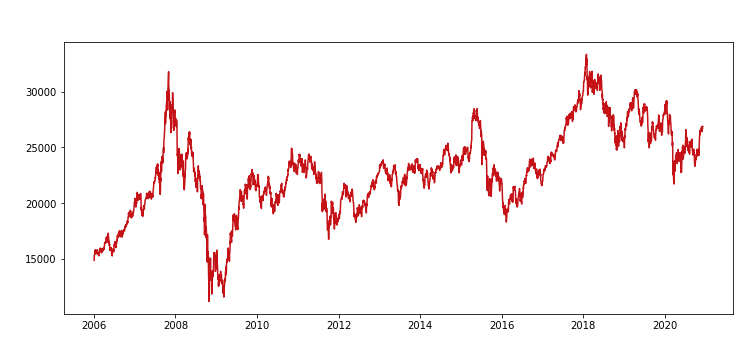



################################################################################




###################################   ^FTSE   ###################################

. Period: from 2006-01-03 to 2020-12-07
. Trading sessions: 3761
. Zero volumes:  0.00%
. Data:



,high,close,open,low,volume
date,,,,,
2006-01-03,5682.200195,5681.500000,5618.799805,5618.799805,1.838005e+09
2006-01-04,5716.399902,5714.600098,5681.500000,5681.500000,2.005345e+09
2006-01-05,5722.399902,5691.200195,5714.600098,5686.399902,1.862547e+09
2006-01-06,5731.799805,5731.799805,5691.200195,5691.200195,1.894952e+09
2006-01-09,5750.299805,5731.500000,5731.799805,5725.899902,1.690826e+09
...,...,...,...,...,...
2020-12-01,6400.200195,6384.700195,6266.200195,6263.600098,8.398583e+08
2020-12-02,6468.600098,6463.399902,6384.700195,6367.500000,9.368428e+08
2020-12-03,6491.500000,6490.299805,6463.399902,6430.299805,9.432145e+08



. Statistics:



,high,close,open,low,volume
count,3761.000000,3761.000000,3761.000000,3761.000000,3.761000e+03
mean,6285.109601,6244.021854,6243.803907,6201.252755,9.904213e+08
std,842.072151,849.639547,849.681338,858.198892,4.277517e+08
min,3564.800049,3512.100098,3512.100098,3460.699951,6.676710e+07
25%,5792.899902,5760.299805,5759.299805,5712.899902,6.934767e+08
50%,6288.700195,6243.700195,6243.399902,6204.500000,8.476476e+08
75%,6866.399902,6837.200195,6837.200195,6806.899902,1.178182e+09
max,7903.500000,7877.500000,7877.500000,7854.600098,3.761301e+09



. Plot:



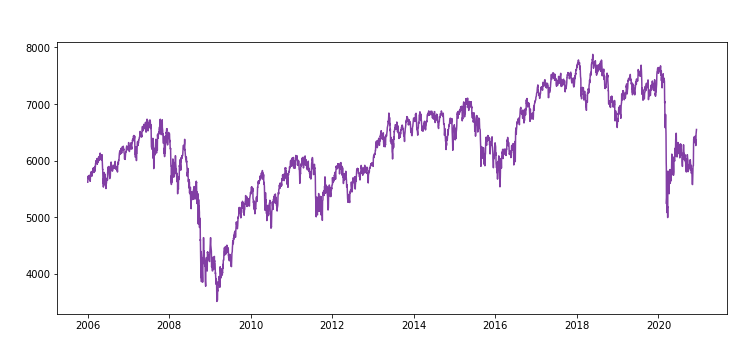



################################################################################




###################################   ^AEX   ###################################

. Period: from 2006-01-02 to 2020-12-07
. Trading sessions: 3819
. Zero volumes:  0.18%
. Data:



,high,close,open,low,volume
date,,,,,
2006-01-02,440.649994,440.519989,437.549988,437.549988,41662000.0
2006-01-03,445.790009,441.929993,441.369995,439.940002,119866000.0
2006-01-04,446.720001,445.000000,445.640015,443.179993,129841000.0
2006-01-05,445.119995,443.130005,444.989990,442.390015,105457000.0
2006-01-06,446.109985,446.109985,443.369995,442.980011,102209400.0
...,...,...,...,...,...
2020-12-01,613.409973,611.409973,609.000000,607.299988,108100.0
2020-12-02,612.320007,610.940002,608.760010,607.729980,99300.0
2020-12-03,613.260010,610.479980,612.429993,608.390015,89300.0



. Statistics:



,high,close,open,low,volume
count,3819.000000,3819.000000,3819.000000,3819.000000,3.819000e+03
mean,434.846489,432.174320,432.266101,429.337819,1.067152e+08
std,97.407166,97.441811,97.380090,97.457414,4.440557e+07
min,200.740005,199.250000,199.339996,194.990005,0.000000e+00
25%,346.125000,344.119995,344.175003,342.339996,7.991060e+07
50%,444.329987,440.989990,441.029999,437.519989,9.910190e+07
75%,519.955017,517.869995,517.794983,515.410004,1.241506e+08
max,632.119995,629.229980,630.559998,627.489990,5.278209e+08



. Plot:



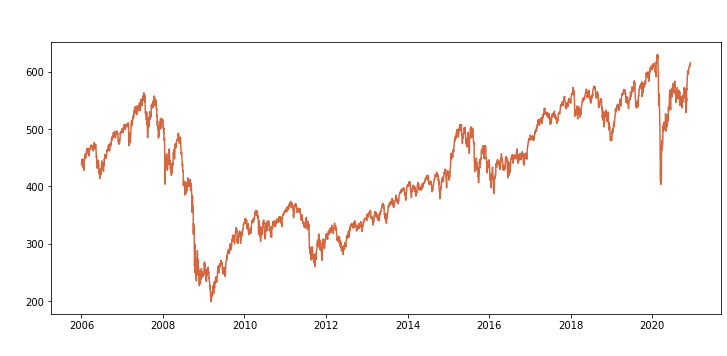



################################################################################




###################################   ^IBEX   ###################################

. Period: from 2006-01-02 to 2020-12-07
. Trading sessions: 3812
. Zero volumes:  0.10%
. Data:



,high,close,open,low,volume
date,,,,,
2006-01-02,10814.599609,10786.700195,10725.799805,10720.000000,63200.0
2006-01-03,10839.299805,10818.099609,10794.099609,10769.299805,127200.0
2006-01-04,10898.900391,10895.799805,10869.299805,10830.900391,199400.0
2006-01-05,10929.599609,10913.599609,10907.299805,10883.299805,127200.0
2006-01-06,10929.599609,10913.599609,10907.299805,10883.299805,0.0
...,...,...,...,...,...
2020-12-01,8176.399902,8140.799805,8112.700195,8100.200195,284946100.0
2020-12-02,8226.200195,8220.799805,8111.100098,8104.200195,310837500.0
2020-12-03,8223.400391,8200.700195,8208.099609,8154.799805,233469300.0



. Statistics:



,high,close,open,low,volume
count,3812.000000,3812.000000,3812.000000,3812.000000,3.812000e+03
mean,10191.853757,10111.757564,10115.854780,10024.897273,1.610462e+08
std,1992.297581,1992.083534,1990.466707,1989.102422,1.329061e+08
min,6093.100098,5956.299805,5950.399902,5814.500000,0.000000e+00
25%,8820.700195,8740.675049,8749.250244,8671.275391,2.786000e+05
50%,9966.199707,9887.250000,9892.200195,9802.100098,1.719008e+08
75%,11056.349609,10966.325195,10986.000000,10888.999756,2.487419e+08
max,16040.400391,15945.700195,15999.200195,15868.599609,9.752120e+08



. Plot:



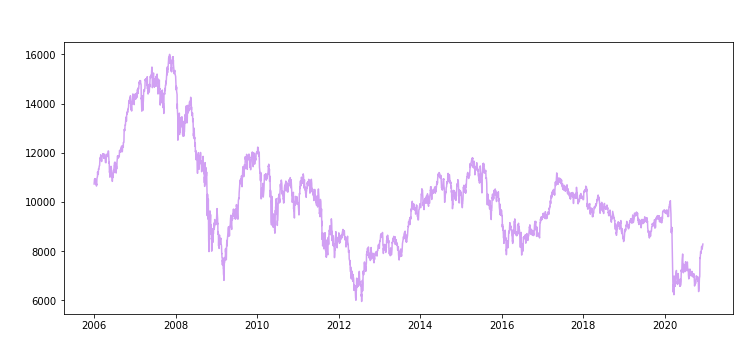



################################################################################




###################################   ^ATX   ###################################

. Period: from 2006-01-02 to 2020-12-07
. Trading sessions: 3699
. Zero volumes:  0.49%
. Data:



,high,close,open,low,volume
date,,,,,
2006-01-02,3695.360107,3682.350098,3667.469971,3653.560059,1894600.0
2006-01-03,3717.419922,3717.419922,3681.790039,3680.510010,4852800.0
2006-01-04,3770.010010,3763.889893,3720.639893,3720.639893,4567600.0
2006-01-05,3773.429932,3772.479980,3758.919922,3749.189941,3686200.0
2006-01-09,3831.010010,3815.479980,3772.610107,3772.610107,4487600.0
...,...,...,...,...,...
2020-12-01,2608.260010,2605.399902,2556.229980,2555.959961,4681000.0
2020-12-02,2610.110107,2607.600098,2600.300049,2591.939941,5316500.0
2020-12-03,2621.229980,2614.810059,2606.530029,2582.899902,6176400.0



. Statistics:



,high,close,open,low,volume
count,3699.000000,3699.000000,3699.000000,3699.000000,3.699000e+03
mean,2864.401551,2839.766974,2840.013630,2814.688815,6.097863e+06
std,771.448801,768.783878,768.872116,765.900779,3.108635e+06
min,1432.430054,1411.949951,1412.239990,1379.859985,0.000000e+00
25%,2293.405029,2274.309937,2274.410034,2253.234985,4.262250e+06
50%,2611.030029,2585.840088,2586.129883,2566.300049,5.541700e+06
75%,3288.194946,3266.869995,3267.375000,3249.885010,7.187000e+06
max,5010.930176,4981.870117,4982.430176,4970.919922,8.234560e+07



. Plot:



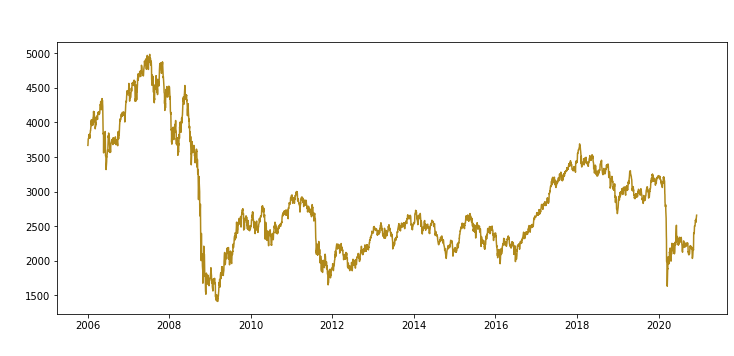



################################################################################




###################################   ^GSPC   ###################################

. Period: from 2006-01-03 to 2020-12-07
. Trading sessions: 3759
. Zero volumes:  0.00%
. Data:



,high,close,open,low,volume
date,,,,,
2006-01-03,1270.219971,1268.800049,1248.290039,1245.739990,2554570000
2006-01-04,1275.369995,1273.459961,1268.800049,1267.739990,2515330000
2006-01-05,1276.910034,1273.479980,1273.459961,1270.300049,2433340000
2006-01-06,1286.089966,1285.449951,1273.479980,1273.479980,2446560000
2006-01-09,1290.780029,1290.150024,1285.449951,1284.819946,2301490000
...,...,...,...,...,...
2020-12-01,3678.449951,3662.449951,3645.870117,3645.870117,5403660000
2020-12-02,3670.959961,3669.010010,3653.780029,3644.840088,5029620000
2020-12-03,3682.729980,3666.719971,3668.280029,3657.169922,5091760000



. Statistics:



,high,close,open,low,volume
count,3759.000000,3759.000000,3759.000000,3759.000000,3.759000e+03
mean,1855.197377,1845.280983,1844.973069,1833.869854,3.886812e+09
std,688.833455,686.678209,686.666996,684.187284,1.188749e+09
min,695.270020,676.530029,679.280029,666.789978,8.325500e+08
25%,1306.385010,1299.540039,1299.650024,1292.544983,3.181560e+09
50%,1651.099976,1640.459961,1640.719971,1633.410034,3.661470e+09
75%,2363.969971,2355.690063,2354.750000,2343.284912,4.335955e+09
max,3699.199951,3699.120117,3694.729980,3678.879883,1.145623e+10



. Plot:



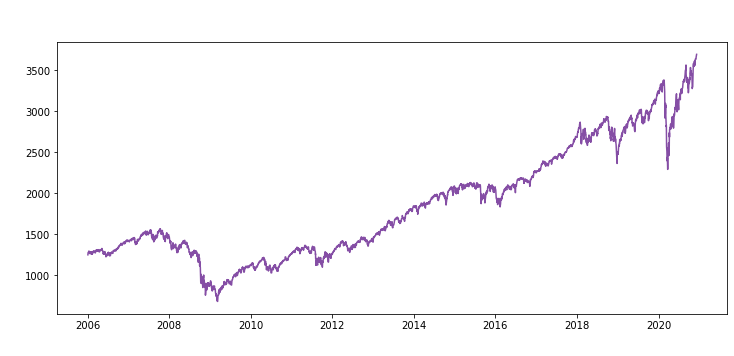



################################################################################


Total number of trading sessions: 74729


In [52]:
visualize = "all"  # "all" or list with specific symbols
total_sessions = 0
for symbol, sdata in multi_data.stocks:
    total_sessions += len(sdata.raw)
    if visualize == "all" or symbol in visualize:
        zero_vols_pc = sdata.raw["volume"].isin([0]).sum() / len(sdata.raw)
        print("\n\n" + "#"*35 + f"   {symbol}   " + "#"*35 + "\n\n" +
              f". Period: from {sdata.raw.index[0]} to {sdata.raw.index[-1]}\n" +
              f". Trading sessions: {len(sdata.raw)}\n" +
              f". Zero volumes: {100*zero_vols_pc : .2f}%\n" 
              f". Data:\n")
        display(sdata.raw)

        print(f"\n. Statistics:\n")
        display(sdata.raw.describe())

        print(f"\n. Plot:\n")
        ax = sdata.raw["open"].plot(figsize=(12,5), color=np.random.rand(1, 3))
        ax.set_title(f"{symbol} opening prices\n", fontsize=16, color="#ffffff");
        ax.set_ylabel("Opening prices", fontsize="14", color="#ffffff");
        ax.set_xlabel("Date", fontsize="14", color="#ffffff");
        plt.show()
        print("\n\n" + "#"*80 + "\n\n")

print(f"Total number of trading sessions: {total_sessions}")
if COLAB: Javascript("google.colab.output.setIframeHeight('250px');")

In [53]:
# data division dates
for symbol, data in multi_data.stocks:
    print(f">>>>> {symbol}")
    print(". Training range: %s to %s" % (
        data.raw_train["features"].index[0], data.raw_train["features"].index[-1]))
    print(". Validation range: %s to %s" % (
        data.raw_val["features"].index[0], data.raw_val["features"].index[-1]))
    print(". Test range: %s to %s\n" % (
        data.raw_test["features"].index[0], data.raw_test["features"].index[-1]))
    
if COLAB: Javascript("google.colab.output.setIframeHeight('100px');")

>>>>> ^MXX
. Training range: 2006-01-02 to 2018-09-06
. Validation range: 2018-09-07 to 2020-03-04
. Test range: 2020-03-05 to 2020-12-02

>>>>> ^BVSP
. Training range: 2006-01-02 to 2018-08-31
. Validation range: 2018-09-03 to 2020-03-05
. Test range: 2020-03-06 to 2020-12-02

>>>>> ^NYA
. Training range: 2006-01-03 to 2018-09-06
. Validation range: 2018-09-07 to 2020-03-05
. Test range: 2020-03-06 to 2020-12-02

>>>>> ^GSPTSE
. Training range: 2006-01-03 to 2018-09-06
. Validation range: 2018-09-07 to 2020-03-05
. Test range: 2020-03-06 to 2020-12-02

>>>>> ^GDAXI
. Training range: 2006-01-02 to 2018-08-31
. Validation range: 2018-09-03 to 2020-03-05
. Test range: 2020-03-06 to 2020-12-02

>>>>> ^N225
. Training range: 2006-01-04 to 2018-08-27
. Validation range: 2018-08-28 to 2020-03-04
. Test range: 2020-03-05 to 2020-12-03

>>>>> ^IXIC
. Training range: 2006-01-03 to 2018-09-06
. Validation range: 2018-09-07 to 2020-03-05
. Test range: 2020-03-06 to 2020-12-02

>>>>> ^KS11
. Train

In [54]:
# comparing normalized values of the training sets
print("#"*20 + " Normalized training data " + "#"*20)
for symbol, data in multi_data.stocks:
    print(f"\n>>>>> {symbol}")
    display(data.norm_train["features"].tail())

if COLAB: Javascript("google.colab.output.setIframeHeight('150px');")

#################### Normalized training data ####################

>>>>> ^MXX


,high,close,open,low,volume
date,,,,,
2018-08-31,0.946358,0.938229,0.941277,0.936489,0.091566
2018-09-03,0.941403,0.936541,0.942252,0.940012,0.008379
2018-09-04,0.936076,0.919304,0.939883,0.922444,0.073647
2018-09-05,0.918981,0.911067,0.918874,0.913121,0.078864
2018-09-06,0.917837,0.914389,0.915249,0.915254,0.064735



>>>>> ^BVSP


,high,close,open,low,volume
date,,,,,
2018-08-27,0.818607,0.832990,0.804418,0.810092,0.011842
2018-08-28,0.819135,0.825140,0.833004,0.825402,0.012765
2018-08-29,0.832243,0.840874,0.825171,0.829727,0.013466
2018-08-30,0.825311,0.806778,0.840924,0.811960,0.015270
2018-08-31,0.804427,0.811484,0.806514,0.805975,0.017849



>>>>> ^NYA


,high,close,open,low,volume
date,,,,,
2018-08-30,0.941790,0.936552,0.946830,0.944455,0.244599
2018-08-31,0.935597,0.934104,0.937497,0.938688,0.251414
2018-09-04,0.929919,0.929106,0.934154,0.934714,0.268593
2018-09-05,0.929157,0.928967,0.930737,0.932547,0.282925
2018-09-06,0.930881,0.925818,0.932462,0.931778,0.274051



>>>>> ^GSPTSE


,high,close,open,low,volume
date,,,,,
2018-08-30,0.983433,0.978246,0.979454,0.979071,0.252181
2018-08-31,0.977945,0.966169,0.977893,0.968342,0.252839
2018-09-04,0.965112,0.954880,0.968495,0.957281,0.278851
2018-09-05,0.951671,0.952247,0.953916,0.944123,0.297572
2018-09-06,0.956103,0.948170,0.955864,0.949024,0.266826



>>>>> ^GDAXI


,high,close,open,low,volume
date,,,,,
2018-08-27,0.895403,0.896768,0.887436,0.890374,0.105669
2018-08-28,0.898907,0.895668,0.899143,0.900252,0.147566
2018-08-29,0.896080,0.899131,0.896639,0.897443,0.117796
2018-08-30,0.892060,0.892314,0.892870,0.887431,0.149159
2018-08-31,0.881703,0.879155,0.882942,0.882273,0.182742



>>>>> ^N225


,high,close,open,low,volume
date,,,,,
2018-08-21,0.892973,0.888429,0.884343,0.889849,0.091566
2018-08-22,0.897869,0.896796,0.893714,0.896330,0.095934
2018-08-23,0.902146,0.899624,0.902565,0.909039,0.084173
2018-08-24,0.910321,0.910811,0.906287,0.913444,0.084677
2018-08-27,0.924170,0.922403,0.918607,0.927034,0.084341



>>>>> ^IXIC


,high,close,open,low,volume
date,,,,,
2018-08-30,1.000000,0.996882,1.000000,0.998571,0.413885
2018-08-31,0.998023,0.999978,0.997813,1.000000,0.387446
2018-09-04,0.995712,0.997305,0.999082,0.994545,0.463530
2018-09-05,0.991865,0.983260,0.996964,0.982835,0.548305
2018-09-06,0.980735,0.972671,0.985912,0.971555,0.495652



>>>>> ^KS11


,high,close,open,low,volume
date,,,,,
2018-08-28,0.821721,0.822187,0.833726,0.830069,0.001062
2018-08-29,0.818844,0.825748,0.829256,0.830517,0.001029
2018-08-30,0.825531,0.824736,0.834305,0.833613,0.001100
2018-08-31,0.826768,0.834095,0.825354,0.827868,0.000981
2018-09-03,0.824232,0.824543,0.837185,0.831673,0.000884



>>>>> ^BSESN


,high,close,open,low,volume
date,,,,,
2018-08-27,0.991775,0.993411,0.983241,0.988931,0.024956
2018-08-28,0.998349,1.000000,0.994338,1.000000,0.022710
2018-08-29,1.000000,0.994349,1.000000,0.997392,0.026454
2018-08-30,0.994449,0.993281,0.993762,0.994246,0.024956
2018-08-31,0.995080,0.991816,0.990779,0.993614,0.042925



>>>>> ^AORD


,high,close,open,low,volume
date,,,,,
2018-09-04,0.879094,0.878484,0.893210,0.888320,0.118315
2018-09-05,0.873051,0.862530,0.888311,0.876075,0.164341
2018-09-06,0.857223,0.843448,0.872290,0.854446,0.156132
2018-09-07,0.838133,0.839306,0.852967,0.841662,0.127097
2018-09-10,0.836662,0.838611,0.848773,0.847596,0.110174



>>>>> ^RUT


,high,close,open,low,volume
date,,,,,
2018-08-29,0.996345,0.995707,0.991568,0.997028,0.206562
2018-08-30,0.998969,0.993989,0.995371,1.000000,0.207507
2018-08-31,1.000000,1.000000,0.993319,0.999683,0.214657
2018-09-04,0.999070,0.994726,1.000000,0.995203,0.232679
2018-09-05,0.993252,0.990626,0.994208,0.989064,0.247715



>>>>> 000001.SS


,high,close,open,low,volume
date,,,,,
2018-08-22,0.313765,0.312282,0.320438,0.317118,0.109322
2018-08-23,0.314585,0.314321,0.316946,0.315425,0.114806
2018-08-24,0.317177,0.315300,0.317398,0.316352,0.117256
2018-08-27,0.323666,0.325780,0.321329,0.322705,0.154941
2018-08-28,0.325789,0.325186,0.330724,0.329485,0.138490



>>>>> ^FCHI


,high,close,open,low,volume
date,,,,,
2018-08-30,0.814841,0.810875,0.817667,0.823087,0.121010
2018-08-31,0.807173,0.791360,0.811284,0.805549,0.167777
2018-09-03,0.792349,0.793264,0.792015,0.801175,0.091534
2018-09-04,0.795326,0.773779,0.798329,0.783505,0.149176
2018-09-05,0.766497,0.751174,0.770403,0.766287,0.194916



>>>>> ^DJI


,high,close,open,low,volume
date,,,,,
2018-08-30,0.974263,0.968620,0.975782,0.974930,0.284514
2018-08-31,0.970469,0.967519,0.969086,0.972173,0.324979
2018-09-04,0.967602,0.966904,0.966652,0.968476,0.301877
2018-09-05,0.969584,0.968025,0.966840,0.971736,0.344316
2018-09-06,0.972722,0.969066,0.969494,0.972227,0.311417



>>>>> ^HSI


,high,close,open,low,volume
date,,,,,
2018-08-30,0.772271,0.774595,0.783528,0.785082,0.131868
2018-08-31,0.745960,0.762151,0.750359,0.767032,0.196269
2018-09-03,0.739527,0.754200,0.750865,0.760584,0.142551
2018-09-04,0.747012,0.765981,0.742287,0.759988,0.112493
2018-09-05,0.741358,0.733029,0.749944,0.743992,0.195287



>>>>> ^FTSE


,high,close,open,low,volume
date,,,,,
2018-09-05,0.897296,0.886792,0.903880,0.886980,0.190207
2018-09-06,0.883421,0.872062,0.886792,0.876761,0.177810
2018-09-07,0.867426,0.862601,0.872062,0.857188,0.215518
2018-09-10,0.862724,0.862968,0.862601,0.863879,0.170402
2018-09-11,0.856409,0.861639,0.862968,0.855686,0.156271



>>>>> ^AEX


,high,close,open,low,volume
date,,,,,
2018-08-30,0.967142,0.965861,0.972363,0.965887,0.158322
2018-08-31,0.960761,0.952731,0.965467,0.957549,0.171322
2018-09-03,0.956295,0.956338,0.956281,0.956943,0.090576
2018-09-04,0.959352,0.939441,0.961952,0.941403,0.165772
2018-09-05,0.934735,0.922199,0.938415,0.927446,0.179273



>>>>> ^IBEX


,high,close,open,low,volume
date,,,,,
2018-08-31,0.339539,0.344645,0.349883,0.348258,0.218702
2018-09-03,0.334613,0.342343,0.342061,0.346351,0.113178
2018-09-04,0.336071,0.342363,0.344748,0.341594,0.202457
2018-09-05,0.330190,0.334855,0.338628,0.340851,0.228888
2018-09-06,0.321565,0.325585,0.330119,0.331507,0.203865



>>>>> ^ATX


,high,close,open,low,volume
date,,,,,
2018-09-03,0.530091,0.532572,0.528840,0.534759,0.028497
2018-09-04,0.530256,0.528847,0.532383,0.532013,0.034009
2018-09-05,0.522937,0.523398,0.528916,0.527541,0.044482
2018-09-06,0.520894,0.515258,0.523207,0.520913,0.036025
2018-09-07,0.512329,0.518491,0.515866,0.517499,0.042561



>>>>> ^GSPC


,high,close,open,low,volume
date,,,,,
2018-08-30,0.998181,0.994230,1.000000,0.998575,0.185400
2018-08-31,0.995417,0.994404,0.995259,0.997011,0.192750
2018-09-04,0.992653,0.992259,0.994627,0.994054,0.211274
2018-09-05,0.989965,0.988630,0.992219,0.990375,0.226729
2018-09-06,0.988993,0.983915,0.990895,0.986059,0.217160


In [55]:
# comparing normalized values of the validation sets
print("#"*20 + " Normalized validation data " + "#"*20)
for symbol, data in multi_data.stocks:
    print(f"\n>>>>> {symbol}")
    display(data.norm_val["features"].tail())

if COLAB: Javascript("google.colab.output.setIframeHeight('150px');")

#################### Normalized validation data ####################

>>>>> ^MXX


,high,close,open,low,volume
date,,,,,
2020-02-27,0.734686,0.711754,0.740004,0.714734,0.125931
2020-02-28,0.707901,0.703679,0.701952,0.666677,0.216458
2020-03-02,0.729960,0.727722,0.707890,0.710483,0.151807
2020-03-03,0.751918,0.736421,0.731323,0.731484,0.137353
2020-03-04,0.761902,0.763019,0.745712,0.748642,0.089388



>>>>> ^BVSP


,high,close,open,low,volume
date,,,,,
2020-02-28,1.278933,1.283744,1.263438,1.219852,0.048343
2020-03-02,1.332559,1.325879,1.285358,1.286073,0.038139
2020-03-03,1.360428,1.307190,1.326072,1.296902,0.040409
2020-03-04,1.342922,1.336168,1.307347,1.307921,0.036211
2020-03-05,1.332506,1.250438,1.336156,1.229972,0.037021



>>>>> ^NYA


,high,close,open,low,volume
date,,,,,
2020-02-28,0.883012,0.866530,0.888373,0.838124,0.747528
2020-03-02,0.913380,0.914031,0.877076,0.869300,0.556588
2020-03-03,0.933297,0.883720,0.920169,0.881733,0.554802
2020-03-04,0.932845,0.933367,0.904320,0.907528,0.439541
2020-03-05,0.908711,0.889064,0.909044,0.887851,0.486683



>>>>> ^GSPTSE


,high,close,open,low,volume
date,,,,,
2020-02-28,0.965179,0.966191,0.958322,0.929045,0.687190
2020-03-02,0.997773,0.998433,0.973886,0.958837,0.436287
2020-03-03,1.023810,0.984023,1.012620,0.982239,0.457717
2020-03-04,1.021707,1.023565,1.010959,1.000022,0.318689
2020-03-05,1.011067,0.998511,0.997863,0.990893,0.364439



>>>>> ^GDAXI


,high,close,open,low,volume
date,,,,,
2020-02-28,0.839413,0.831273,0.829772,0.819347,0.555905
2020-03-02,0.850839,0.827990,0.843752,0.809327,0.419451
2020-03-03,0.866145,0.840879,0.842013,0.837748,0.396623
2020-03-04,0.858747,0.855263,0.839946,0.840006,0.299275
2020-03-05,0.859551,0.836769,0.860028,0.831509,0.299762



>>>>> ^N225


,high,close,open,low,volume
date,,,,,
2020-02-27,0.890943,0.872523,0.892880,0.877507,0.178427
2020-02-28,0.847244,0.825347,0.849527,0.822675,0.249496
2020-03-02,0.851060,0.837129,0.810264,0.817822,0.207829
2020-03-03,0.858499,0.821818,0.857400,0.832504,0.176915
2020-03-04,0.830672,0.822833,0.813050,0.819463,0.158938



>>>>> ^IXIC


,high,close,open,low,volume
date,,,,,
2020-02-28,1.067260,1.066902,1.025779,1.027129,1.172562
2020-03-02,1.120213,1.123151,1.084140,1.068103,0.925940
2020-03-03,1.137450,1.083964,1.127897,1.076841,0.949933
2020-03-04,1.130063,1.132787,1.108659,1.099555,0.780542
2020-03-05,1.115559,1.091930,1.102196,1.087775,0.814063



>>>>> ^KS11


,high,close,open,low,volume
date,,,,,
2020-03-02,0.640377,0.641036,0.645439,0.635358,0.002026
2020-03-03,0.661575,0.648050,0.678195,0.658981,0.002361
2020-03-04,0.668731,0.675276,0.650685,0.656870,0.002325
2020-03-05,0.684267,0.690902,0.693886,0.688827,0.002590
2020-03-06,0.668109,0.663760,0.678936,0.672394,0.003320



>>>>> ^BSESN


,high,close,open,low,volume
date,,,,,
2020-03-02,1.003043,0.975514,0.997452,0.968626,0.031445
2020-03-03,0.992340,0.991120,0.983528,0.980096,0.024457
2020-03-04,0.993559,0.984151,0.991131,0.970561,0.036187
2020-03-05,0.996686,0.986139,0.987522,0.987963,0.031695
2020-03-06,0.959565,0.957054,0.955459,0.943680,0.045421



>>>>> ^AORD


,high,close,open,low,volume
date,,,,,
2020-03-03,0.926633,0.908603,0.905280,0.908951,0.244695
2020-03-04,0.903318,0.878377,0.918947,0.888239,0.235580
2020-03-05,0.906821,0.898127,0.888339,0.892068,0.228357
2020-03-06,0.892837,0.848713,0.908338,0.862132,0.229711
2020-03-09,0.843346,0.724418,0.858245,0.736697,0.366865



>>>>> ^RUT


,high,close,open,low,volume
date,,,,,
2020-02-27,0.864380,0.826203,0.859662,0.831951,0.597310
2020-02-28,0.823177,0.810861,0.824913,0.797556,0.735131
2020-03-02,0.838808,0.840958,0.810387,0.808268,0.534815
2020-03-03,0.854114,0.817766,0.840479,0.815251,0.532942
2020-03-04,0.847957,0.850053,0.827295,0.831006,0.412021



>>>>> 000001.SS


,high,close,open,low,volume
date,,,,,
2020-02-27,0.369905,0.368628,0.373678,0.372750,0.408937
2020-02-28,0.357497,0.346021,0.359813,0.351856,0.468090
2020-03-02,0.364452,0.364474,0.354637,0.356112,0.428538
2020-03-03,0.373422,0.368947,0.376620,0.371959,0.478474
2020-03-04,0.370420,0.372769,0.371495,0.371495,0.412204



>>>>> ^FCHI


,high,close,open,low,volume
date,,,,,
2020-02-27,0.846638,0.815682,0.839025,0.810526,0.407208
2020-02-28,0.780895,0.764790,0.767308,0.757946,0.505354
2020-03-02,0.795832,0.771263,0.796226,0.749174,0.379943
2020-03-03,0.817748,0.787610,0.794062,0.796911,0.350619
2020-03-04,0.813314,0.807266,0.791940,0.792987,0.286991



>>>>> ^DJI


,high,close,open,low,volume
date,,,,,
2020-02-28,0.943615,0.939842,0.934450,0.912131,1.112871
2020-03-02,1.004494,1.004315,0.950404,0.947741,0.771020
2020-03-03,1.023503,0.965156,1.008893,0.963484,0.783135
2020-03-04,1.024395,1.023625,0.989989,0.992536,0.550783
2020-03-05,1.002773,0.975314,1.004374,0.975357,0.575037



>>>>> ^HSI


,high,close,open,low,volume
date,,,,,
2020-02-27,0.694782,0.712015,0.693146,0.708513,0.215363
2020-02-28,0.670123,0.682713,0.680517,0.689136,0.325685
2020-03-02,0.672992,0.690019,0.672793,0.693111,0.224667
2020-03-03,0.679977,0.689709,0.688185,0.700116,0.218009
2020-03-04,0.672834,0.686875,0.683786,0.691340,0.199718



>>>>> ^FTSE


,high,close,open,low,volume
date,,,,,
2020-02-28,0.744831,0.702914,0.752348,0.682628,0.517810
2020-03-02,0.739945,0.719934,0.702914,0.690799,0.461243
2020-03-03,0.756332,0.734434,0.719934,0.726962,0.327625
2020-03-04,0.758637,0.756746,0.734434,0.737272,0.283937
2020-03-05,0.753521,0.731502,0.756746,0.728715,0.292358



>>>>> ^AEX


,high,close,open,low,volume
date,,,,,
2020-02-27,0.991227,0.956869,0.986820,0.943619,0.315009
2020-02-28,0.911607,0.902226,0.910858,0.886975,0.484307
2020-03-02,0.939972,0.909626,0.936179,0.884231,0.335650
2020-03-03,0.953344,0.941404,0.937643,0.933409,0.129287
2020-03-04,0.958502,0.950901,0.934954,0.929689,0.274089



>>>>> ^IBEX


,high,close,open,low,volume
date,,,,,
2020-02-28,0.273994,0.276984,0.278411,0.268726,0.630766
2020-03-02,0.283534,0.278816,0.294543,0.264551,0.450272
2020-03-03,0.293668,0.285833,0.289567,0.288168,0.444869
2020-03-04,0.288581,0.295683,0.286343,0.285106,0.406919
2020-03-05,0.288460,0.272959,0.299578,0.274467,0.434209



>>>>> ^ATX


,high,close,open,low,volume
date,,,,,
2020-03-04,0.394839,0.388404,0.391685,0.391943,0.098293
2020-03-05,0.390767,0.366678,0.388486,0.370361,0.104450
2020-03-06,0.359919,0.337153,0.366412,0.337207,0.119372
2020-03-09,0.330312,0.271149,0.336736,0.275409,0.199405
2020-03-10,0.301341,0.265961,0.270770,0.270683,0.163360



>>>>> ^GSPC


,high,close,open,low,volume
date,,,,,
2020-02-28,1.019458,1.017957,1.003570,0.980929,0.727742
2020-03-02,1.078542,1.078744,1.029305,1.020967,0.521839
2020-03-03,1.099143,1.039924,1.084103,1.035055,0.519913
2020-03-04,1.096555,1.096572,1.061359,1.060934,0.395619
2020-03-05,1.074976,1.049117,1.074792,1.045452,0.446455


In [56]:
# comparing normalized values of the test sets
print("#"*20 + " Normalized test data " + "#"*20)
for symbol, data in multi_data.stocks:
    print(f"\n>>>>> {symbol}")
    display(data.norm_test["features"].tail())

if COLAB: Javascript("google.colab.output.setIframeHeight('150px');")

#################### Normalized test data ####################

>>>>> ^MXX


,high,close,open,low,volume
date,,,,,
2020-11-26,0.734144,0.734716,0.728812,0.725613,0.057990
2020-11-27,0.735662,0.713662,0.740432,0.716785,0.051934
2020-11-30,0.715616,0.716645,0.716560,0.712351,0.454677
2020-12-01,0.754505,0.748497,0.724969,0.725569,0.127542
2020-12-02,0.769600,0.770722,0.754269,0.755630,0.099033



>>>>> ^BVSP


,high,close,open,low,volume
date,,,,,
2020-11-26,1.385781,1.387749,1.386250,1.383621,0.026551
2020-11-27,1.409673,1.393727,1.387899,1.396474,0.037846
2020-11-30,1.397903,1.364750,1.394238,1.373432,0.083095
2020-12-01,1.413843,1.406781,1.365017,1.374609,0.048758
2020-12-02,1.422200,1.415009,1.408050,1.403705,0.042255



>>>>> ^NYA


,high,close,open,low,volume
date,,,,,
2020-11-25,1.065750,1.058929,1.070112,1.062293,0.427938
2020-11-27,1.063562,1.059664,1.063928,1.066953,0.242527
2020-11-30,1.054097,1.039257,1.058522,1.046792,0.549168
2020-12-01,1.064028,1.054153,1.063060,1.063279,0.471679
2020-12-02,1.060306,1.058574,1.054584,1.057442,0.439029



>>>>> ^GSPTSE


,high,close,open,low,volume
date,,,,,
2020-11-26,1.087738,1.087095,1.082504,1.084191,0.115040
2020-11-27,1.092732,1.092128,1.083677,1.085836,0.218269
2020-11-30,1.084713,1.069207,1.086212,1.064653,0.519081
2020-12-01,1.099503,1.081051,1.096353,1.082358,0.345509
2020-12-02,1.086805,1.087862,1.079393,1.075250,0.305004



>>>>> ^GDAXI


,high,close,open,low,volume
date,,,,,
2020-11-26,0.971620,0.972402,0.973543,0.975534,0.086945
2020-11-27,0.976471,0.977366,0.970038,0.975318,0.129194
2020-11-30,0.984654,0.972866,0.969028,0.973708,0.217336
2020-12-01,0.983561,0.982079,0.979245,0.981587,0.134967
2020-12-02,0.975975,0.975098,0.976240,0.975290,0.129191



>>>>> ^N225


,high,close,open,low,volume
date,,,,,
2020-11-27,1.149341,1.147667,1.144035,1.147847,0.144825
2020-11-30,1.158842,1.135301,1.161651,1.147066,0.248152
2020-12-01,1.159897,1.156035,1.149553,1.159627,0.122984
2020-12-02,1.162113,1.156823,1.164877,1.164171,0.134745
2020-12-03,1.160833,1.157314,1.156375,1.165586,0.116767



>>>>> ^IXIC


,high,close,open,low,volume
date,,,,,
2020-11-25,1.584037,1.582471,1.581507,1.578480,0.970322
2020-11-27,1.601854,1.598762,1.596969,1.598090,0.734149
2020-11-30,1.603089,1.597723,1.606525,1.579391,1.724771
2020-12-01,1.626727,1.620580,1.619612,1.614140,1.441714
2020-12-02,1.620019,1.619741,1.615557,1.607304,1.137857



>>>>> ^KS11


,high,close,open,low,volume
date,,,,,
2020-11-27,1.017005,1.021248,1.020549,1.018238,0.004587
2020-11-30,1.025331,0.995872,1.034442,1.002235,0.005031
2020-12-01,1.019364,1.021730,1.013749,1.014227,0.004412
2020-12-02,1.042762,1.046829,1.033145,1.033609,0.004128
2020-12-03,1.054319,1.059074,1.057345,1.050313,0.003134



>>>>> ^BSESN


,high,close,open,low,volume
date,,,,,
2020-11-25,1.189900,1.160445,1.186496,1.160878,0.045670
2020-11-26,1.174815,1.174488,1.161172,1.155226,0.034440
2020-11-27,1.176295,1.170909,1.172745,1.168522,0.037185
2020-12-01,1.186823,1.187362,1.176332,1.172472,0.037934
2020-12-02,1.186785,1.186145,1.185841,1.174142,0.037934



>>>>> ^AORD


,high,close,open,low,volume
date,,,,,
2020-11-27,0.993476,0.990165,1.010203,1.001294,0.134627
2020-11-30,0.996684,0.970202,1.001543,0.984735,0.291413
2020-12-01,0.989465,0.988936,0.981327,0.982173,0.176274
2020-12-02,0.991337,0.988696,1.000298,0.996143,0.181673
2020-12-03,0.996925,0.998316,1.000054,1.003398,0.175089



>>>>> ^RUT


,high,close,open,low,volume
date,,,,,
2020-11-25,1.079688,1.074612,1.080249,1.074373,0.399849
2020-11-27,1.081598,1.081947,1.075684,1.084147,0.205334
2020-11-30,1.081310,1.056580,1.081863,1.061107,0.527032
2020-12-01,1.076371,1.068194,1.058934,1.067859,0.445737
2020-12-02,1.072413,1.069611,1.066225,1.063603,0.411484



>>>>> 000001.SS


,high,close,open,low,volume
date,,,,,
2020-11-26,0.443138,0.445679,0.448791,0.447318,0.298565
2020-11-27,0.450594,0.453533,0.451608,0.451460,0.327383
2020-11-30,0.460392,0.450164,0.460664,0.457049,0.449189
2020-12-01,0.460574,0.462418,0.454703,0.456055,0.368918
2020-12-02,0.462211,0.461897,0.467889,0.466090,0.364952



>>>>> ^FCHI


,high,close,open,low,volume
date,,,,,
2020-11-26,0.840845,0.835192,0.843880,0.848479,0.123772
2020-11-27,0.846372,0.843795,0.836639,0.847629,0.159311
2020-11-30,0.842826,0.821972,0.836947,0.837190,0.000000
2020-12-01,0.839988,0.839262,0.830982,0.840124,0.000000
2020-12-02,0.838934,0.839638,0.836642,0.845756,0.000000



>>>>> ^DJI


,high,close,open,low,volume
date,,,,,
2020-11-25,1.172911,1.162223,1.173406,1.168838,0.385786
2020-11-27,1.170714,1.164111,1.166043,1.169525,0.206774
2020-11-30,1.162645,1.150572,1.163207,1.151678,0.665751
2020-12-01,1.174139,1.159804,1.160362,1.168399,0.516351
2020-12-02,1.165057,1.162787,1.155251,1.158472,0.462117



>>>>> ^HSI


,high,close,open,low,volume
date,,,,,
2020-11-26,0.693397,0.713859,0.700633,0.717154,0.201819
2020-11-27,0.702124,0.717257,0.703484,0.721322,0.278964
2020-11-30,0.699905,0.692269,0.707763,0.704134,0.585977
2020-12-01,0.686161,0.702486,0.688346,0.706500,0.363731
2020-12-02,0.686527,0.700901,0.699500,0.706690,0.378002



>>>>> ^FTSE


,high,close,open,low,volume
date,,,,,
2020-11-26,0.656395,0.653044,0.659504,0.657457,0.181215
2020-11-27,0.647913,0.654121,0.653044,0.646692,0.373893
2020-11-30,0.654390,0.630893,0.654121,0.638499,0.348707
2020-12-01,0.653514,0.658038,0.630893,0.637907,0.209253
2020-12-02,0.669279,0.676066,0.658038,0.661554,0.235503



>>>>> ^AEX


,high,close,open,low,volume
date,,,,,
2020-11-26,1.088340,1.082628,1.088823,1.087275,0.131506
2020-11-27,1.097538,1.093981,1.089142,1.089861,0.326835
2020-11-30,1.101579,1.078994,1.091299,1.084426,0.000273
2020-12-01,1.097060,1.093292,1.090740,1.087803,0.000205
2020-12-02,1.094162,1.092045,1.090101,1.088937,0.000188



>>>>> ^IBEX


,high,close,open,low,volume
date,,,,,
2020-11-26,0.210288,0.215058,0.222355,0.218944,0.276530
2020-11-27,0.210871,0.223677,0.210841,0.215702,0.525815
2020-11-30,0.208308,0.212285,0.216961,0.217809,0.690199
2020-12-01,0.209434,0.218682,0.215180,0.220299,0.360924
2020-12-02,0.214440,0.226690,0.215021,0.220700,0.393719



>>>>> ^ATX


,high,close,open,low,volume
date,,,,,
2020-11-26,0.323876,0.326884,0.328576,0.330738,0.049155
2020-11-27,0.329912,0.332503,0.326859,0.332052,0.058485
2020-11-30,0.325413,0.319848,0.331825,0.326692,0.162502
2020-12-01,0.328582,0.334307,0.320428,0.327508,0.056846
2020-12-02,0.329099,0.334923,0.332772,0.337527,0.064563



>>>>> ^GSPC


,high,close,open,low,volume
date,,,,,
2020-11-25,1.323695,1.319824,1.325861,1.322350,0.383107
2020-11-27,1.327661,1.323713,1.327229,1.327535,0.183166
2020-11-30,1.323100,1.316240,1.325269,1.311878,0.513838
2020-12-01,1.343031,1.334483,1.330512,1.334947,0.430276
2020-12-02,1.339659,1.337415,1.334060,1.334485,0.395067


In [57]:
# sample output shape
sample_x, sample_y = next(iter(multi_data.tf_datasets["train"]))
print(f"Sample input shape: {sample_x.shape}")
print(f"Sample label shape: {sample_y.shape}")

Sample input shape: (40, 3, 5)
Sample label shape: (40, 3)


## **2) Defining a model**

In [67]:
class MultiLSTM(tf.keras.Model):
    """ Custom LSTM model. """

    def __init__(self, num_sessions=NUM_SESSIONS, load_path=None):
        super(MultiLSTM, self).__init__()
        if load_path is not None:
            self.custom_load(load_path)
        else:
            self._num_sessions = num_sessions
            
            # opening price predictor (reference architecture)
            self._open_predictor = tf.keras.models.Sequential([                                              
                self._conv_lstm_block(64, dropout=0.4),
                tf.keras.layers.LSTM(64, return_sequences=False),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Dense(1, activation="linear"),
            ])

            # lowest price predictor
            self._pre_lowest = tf.keras.models.Sequential([
                tf.keras.layers.LSTM(32, return_sequences=True),
            ])
            self._lowest_predictor = tf.keras.models.Sequential([
                self._conv_lstm_block(32, dropout=0.4),
                tf.keras.layers.LSTM(32, return_sequences=False),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Dense(1, activation="linear"),
            ])

            # highest price predictor
            self._pre_highest = tf.keras.models.Sequential([
                tf.keras.layers.LSTM(32, return_sequences=True),
            ])
            self._highest_predictor = tf.keras.models.clone_model(self._lowest_predictor)

    def _conv_lstm_block(self, units, ksize=3, strides=1, dropout=0.25):
        return tf.keras.models.Sequential([
                  tf.keras.layers.LSTM(32, return_sequences=True, recurrent_dropout=dropout),
                  tf.keras.layers.Conv1D(units, kernel_size=ksize, strides=strides, 
                                         padding="valid", activation="relu"),
                  tf.keras.layers.SpatialDropout1D(dropout)])

    def call(self, inputs, training=None):
        # calculating the opening price
        open_price = self._open_predictor(inputs, training=training)

        # cloning prices: expanding shape from (batches, 1) to (batches, NUM_SESSIONS, 1)
        open_price_exp = tf.tile(tf.expand_dims(open_price, -1),   
                                 [1, self._num_sessions, 1])
        # calculating the lowest price
        lowest_price = self._lowest_predictor(
            # appends the opening price to the end of each item in the input sequence
            tf.concat([self._pre_lowest(inputs), open_price_exp], -1),
            training=training,
        )

        # cloning prices: expanding shape from (batches, 1) to (batches, NUM_SESSIONS, 1)
        lowest_price_exp = tf.tile(tf.expand_dims(lowest_price, -1),   
                                   [1, self._num_sessions, 1])

        # calculating the highest price
        highest_price = self._highest_predictor(
            # appends the opening price and the lowest price to the end of each item in the input sequence
            tf.concat(
                [self._pre_highest(inputs), open_price_exp, lowest_price_exp], -1),
            training=training,
        )

        # returning the concatenation of the opening price, lowest price and highest price
        return tf.concat([open_price, lowest_price, highest_price], -1)
    
    def custom_save(self, dir_path):
        if not os.path.isdir(dir_path):
            os.makedirs(dir_path)
            
        with open(os.path.join(dir_path, "info.txt"), "w") as file:
            file.write("num_sessions %d" % self._num_sessions)
        
        pred_dir = os.path.join(dir_path, "predictors")
        if not os.path.isdir(pred_dir):
            os.makedirs(pred_dir)
            
        pre_dir = os.path.join(dir_path, "pre_layers")
        if not os.path.isdir(pre_dir):
            os.makedirs(pre_dir)
            
        # saving predictors
        self._open_predictor.save(os.path.join(pred_dir, "open_predictor"))
        self._open_predictor.save(os.path.join(pred_dir, "open_predictor.h5"))
        
        self._lowest_predictor.save(os.path.join(pred_dir, "low_predictor"))
        self._lowest_predictor.save(os.path.join(pred_dir, "low_predictor.h5"))
        
        self._highest_predictor.save(os.path.join(pred_dir, "high_predictor"))
        self._highest_predictor.save(os.path.join(pred_dir, "high_predictor.h5"))
        
        # saving pre-layers
        self._pre_lowest.save(os.path.join(pred_dir, "pre_low"))
        self._pre_lowest.save(os.path.join(pred_dir, "pre_low.h5"))
        
        self._pre_highest.save(os.path.join(pred_dir, "pre_high"))
        self._pre_highest.save(os.path.join(pred_dir, "pre_high.h5"))
    
    def custom_load(self, dir_path):
        with open(os.path.join(dir_path, "info.txt"), "r") as file:
            self._num_sessions = int(file.readline().split()[1])
            
        pred_dir = os.path.join(dir_path, "predictors")
        pre_dir = os.path.join(dir_path, "pre_layers")
        
        # loading predictors
        self._open_predictor = tf.keras.models.load_model(os.path.join(pred_dir, "open_predictor"))
        self._lowest_predictor = tf.keras.models.load_model(os.path.join(pred_dir, "low_predictor"))
        self._highest_predictor = tf.keras.models.load_model(os.path.join(pred_dir, "high_predictor"))
        
        # saving pre-layers
        self._pre_lowest = tf.keras.models.load_model(os.path.join(pred_dir, "pre_low"))
        self._pre_highest = tf.keras.models.load_model(os.path.join(pred_dir, "pre_high"))

In [68]:
# testing output shape
x, y = next(iter(multi_data.tf_datasets["train"]))
MultiLSTM()(x).shape

TensorShape([40, 3])

## **3) Training**

#### **3.1) Fixing validation data**

In [63]:
# loading all validation data into memory (so we dont have to use a generator)
val_inputs, val_outputs = [], []
for x, y in multi_data.tf_datasets["val"]:
    val_inputs.append(x)
    val_outputs.append(y)

val_inputs = tf.concat(val_inputs, axis=0)
val_outputs = tf.concat(val_outputs, axis=0)

print(val_inputs.shape, val_outputs.shape)

(7421, 3, 5) (7421, 3)


#### **3.2) Fitting the model to the data**

In [ ]:
#@title  { form-width: "250px" }
epochs =    10  #@param {type:"integer"}
learning_rate = 1e-3  #@param {type:"number"}

save_path = f"saved_model_{datetime.today().strftime('%Y-%m-%d-%H-%M-%S')}"
tf.keras.backend.clear_session()

# building and compiling
model = MultiLSTM()
model.compile(loss=tf.losses.MeanSquaredError(),
              optimizer=tf.optimizers.Adam(learning_rate=learning_rate),
              metrics=[])
                       #tf.metrics.MeanAbsoluteError()]) 
                       #tf.metrics.MeanAbsolutePercentageError()])

# training
history = model.fit(
    multi_data.tf_datasets["train"].shuffle(buffer_size=multi_data.size["train"]), 
    epochs=epochs,
    validation_data=(val_inputs, val_outputs),
    callbacks=[ClearCallback(),
               ModelCheckpoint(filepath=os.path.join(save_path, "checkpoint_best"), 
                                                     monitor='val_loss', 
                                                     verbose=1, save_best_only=True)],
)

# restoring the checkpoint of the best model
model.load_weights(os.path.join(save_path, "checkpoint_best"))

# saving the model
model.save(os.path.join(save_path, "full_save"))
model.custom_save(save_path)
shutil.make_archive(save_path, "zip", save_path)

# downloading the model (Colab only)
if COLAB: 
  files.download(f"{save_path}.zip")

# visualizing loss history
clear_output(wait=True)
print(history.history)

plt.rc('xtick',labelsize=12, color="#DCDCDC")
plt.rc('ytick',labelsize=12, color="#DCDCDC")
plt.rcParams.update({'legend.fontsize': 14, 'legend.handlelength': 2})

plt.figure(figsize=(10, 6))
plt.plot(range(epochs), history.history["loss"], 'r--')
plt.plot(range(epochs), history.history["val_loss"], 'b-')
plt.legend(['Training Loss', 'Validation Loss'])

plt.title("Loss History\n", fontsize=17, color="#E0E0E0")
plt.ylabel('MSE\n', fontsize=14, color="#E0E0E0")
plt.xlabel('\nEpoch', fontsize=14, color="#E0E0E0")
plt.show();

if COLAB: Javascript("google.colab.output.setIframeHeight('200px');")


Epoch 00001: val_loss improved from inf to 0.02857, saving model to saved_model_2020-12-11-10-24-39/checkpoint_best
Epoch 2/10
1208/1619 [=====================>........] - ETA: 5s - loss: 0.0308

## **4) Evaluating on all the stocks**

In [ ]:
loss = {}
for mode in ["train", "val", "test"]:
    loss[mode] = model.evaluate(multi_data.tf_datasets[mode])

loss = pd.Series(loss.values(), index=loss.keys())
print("\n\n>>> Loss value (on the normalized data):")
loss

In [ ]:
results, predictions = {}, {}
i = 0
for stk, sdata in multi_data.stocks:
    clear_output(wait=True)
    print(f"[{100*(i+1) / len(multi_data.stocks) : .0f}%] Evaluating stock {i+1} of {len(multi_data.stocks)}... ", end="")
    i += 1

    results[stk], predictions[stk] = {}, {}
    for mode in ["train", "val", "test"]:
        predictions[stk][mode], results[stk][mode] = eval(model, 
                                                          sdata, mode)
    print("done!")

print("\nResults: ")
results

## **5) Visualizing results for individual stocks**

#### **5.1) Training data**

In [ ]:
symbols = ["^BVSP", "^DJI", "^HSI"]

In [ ]:
for symb in symbols:
  print(f"[{symb}] Training Data\n")
  eval_print(results[symb]["train"])
  eval_plot(predictions[symb]["train"], 
            multi_data[symb].raw_train["labels"], 
            start_date="random", 
            plot_samples=100, 
            title="Performance on the Training Set")
  print("\n\n\n" + "="*100 + "\n\n")

if COLAB: Javascript("google.colab.output.setIframeHeight('250px');")

#### **5.2) Validation data**

In [ ]:
for symb in symbols:
  print(f"[{symb}] Validation Data\n")
  eval_print(results[symb]["val"])
  eval_plot(predictions[symb]["val"], 
            multi_data[symb].raw_val["labels"], 
            start_date="random", 
            plot_samples=100, 
            title="Performance on the Validation Set")
  print("\n\n\n" + "="*100 + "\n\n")

if COLAB: Javascript("google.colab.output.setIframeHeight('250px');")

#### **5.3) Test data**

In [ ]:
for symb in symbols:
  print(f"[{symb}] Test Data\n")
  eval_print(results[symb]["test"])
  eval_plot(predictions[symb]["test"], 
            multi_data[symb].raw_test["labels"], 
            start_date="random", 
            plot_samples=100, 
            title="Performance on the Test Set")
  print("\n\n\n" + "="*100 + "\n\n")

if COLAB: Javascript("google.colab.output.setIframeHeight('250px');")